In [1]:
import numpy as np
print('Numpy version:', np.__version__)

import pandas as pd
print('Pandas version:', pd.__version__)

import matplotlib as mpl
print('Matplotlib version:', mpl.__version__)
import matplotlib.pyplot as plt

import seaborn as sns
print('Seaborn version:', sns.__version__)

from copy import deepcopy
from sklearn.base import clone

from sklearn.naive_bayes import BernoulliNB, MultinomialNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV

from sklearn.pipeline import Pipeline

import pickle

from tqdm import tqdm
from pathlib import Path

Numpy version: 1.23.5
Pandas version: 1.5.2
Matplotlib version: 3.6.2
Seaborn version: 0.12.1


In [2]:

from preprocess_classes import (
    DFDropColumns, DFWoeEncoder, DFColumnBinning, DFValuesMapper, DFFuncApplyCols,
    DFCrossFeaturesImputer, DFOneHotEncoder, DFOrdinalEncoder, DFValuesReplacer
)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=29438)

In [6]:
poutcome_func = (lambda x: x + 1)
percentage_func = (lambda x: x + 100)

pl_non_negative = Pipeline([
    ('pdays_enc', DFValuesReplacer(replaces={'pdays': {-1: 999}})),
    ('sum_enc', DFFuncApplyCols(map_func={
            'poutcome': poutcome_func,
            'emp.var.rate': percentage_func,
            'cons.conf.idx': percentage_func
        }
    )),
])

In [7]:
"""
Returnd metrics for model based on train and test set. Optionally shows charts (confusion matrix, ROC curve and Precision-Recall curve)
"""
def get_model_results(model, train_set, test_set=None, show_charts=False):
    metrics = {'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'f1': f1_score, 'auc': roc_auc_score}
    if show_charts:
        if test_set is None:
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            conf_matrix_train = ConfusionMatrixDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0])
            roc_curve_train = RocCurveDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[1])
            pr_curve_train = PrecisionRecallDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[2])
            axs[0].set_title('TRAIN set: confusion matrix')
            axs[1].set_title('TRAIN set: ROC curve')
            axs[2].set_title('TRAIN set: precision-recall curve')
        else:
            fig, axs = plt.subplots(2, 3, figsize=(15, 10))
            conf_matrix_train = ConfusionMatrixDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0, 0])
            roc_curve_train = RocCurveDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0, 1])
            pr_curve_train = PrecisionRecallDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0, 2])
            conf_matrix_test = ConfusionMatrixDisplay.from_estimator(estimator=model, X=test_set[0], y=test_set[1], ax=axs[1, 0])
            roc_curve_test = RocCurveDisplay.from_estimator(estimator=model, X=test_set[0], y=test_set[1], ax=axs[1, 1])
            pr_curve_test = PrecisionRecallDisplay.from_estimator(estimator=model, X=test_set[0], y=test_set[1], ax=axs[1, 2])
            axs[0, 0].set_title('TRAIN set: confusion matrix')
            axs[0, 1].set_title('TRAIN set: ROC curve')
            axs[0, 2].set_title('TRAIN set: precision-recall curve')
            axs[1, 0].set_title('TEST set: confusion matrix')
            axs[1, 1].set_title('TEST set: ROC curve')
            axs[1, 2].set_title('TEST set: precision-recall curve')
    
    results = {}
    print('Scores:')
    print('Indicator  \tTrain \tTest')
    print('='*40)
    for m_name, m_func in metrics.items():
        results[m_name] = {} 
        results[m_name]['train'] = m_func(train_set[1], model.predict(train_set[0]))
        if test_set is not None:
            results[m_name]['test'] = m_func(test_set[1], model.predict(test_set[0]))
        print('{}:     \t{:.4f} \t{:.4f}'.format(m_name, results[m_name]['train'], 0.0 if test_set is None else results[m_name]['test']))
    
    return results

## Plain datasets

In [8]:
dfs_options = [f'opt{x}' for x in range(1, 11)]+['gv']
dfs_types = ['train', 'test']
filename_template = 'datasets/processed/bank-{}-encoded-{}.csv'

In [9]:
dfs = {}
for opt in dfs_options:
    dfs[opt] = {}
    for t in dfs_types:
        filename = filename_template.format(t, opt)
        dfs[opt][t] = pd.read_csv(filename, comment='#')
        print('Loaded {} dataset from {}. {} records, {} features'.format(t.upper(), filename, len(dfs[opt][t]), len(dfs[opt][t].columns)))

print('='*30)
print('Num of fully loaded datasets: {}'.format(len(dfs)))

Loaded TRAIN dataset from datasets/processed/bank-train-encoded-opt1.csv. 28831 records, 20 features
Loaded TEST dataset from datasets/processed/bank-test-encoded-opt1.csv. 12357 records, 20 features
Loaded TRAIN dataset from datasets/processed/bank-train-encoded-opt2.csv. 28831 records, 18 features
Loaded TEST dataset from datasets/processed/bank-test-encoded-opt2.csv. 12357 records, 18 features
Loaded TRAIN dataset from datasets/processed/bank-train-encoded-opt3.csv. 28831 records, 15 features
Loaded TEST dataset from datasets/processed/bank-test-encoded-opt3.csv. 12357 records, 15 features
Loaded TRAIN dataset from datasets/processed/bank-train-encoded-opt4.csv. 28831 records, 20 features
Loaded TEST dataset from datasets/processed/bank-test-encoded-opt4.csv. 12357 records, 20 features
Loaded TRAIN dataset from datasets/processed/bank-train-encoded-opt5.csv. 28831 records, 18 features
Loaded TEST dataset from datasets/processed/bank-test-encoded-opt5.csv. 12357 records, 18 features


In [10]:
models_params = {
    'logistic_regression': {
        'base_estimator': Pipeline([
                ('scale', MinMaxScaler()),
                ('clf', LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', class_weight='balanced', max_iter=5000))
            ]),
        'param_grid': [
            dict(clf__C=np.logspace(-4, 1, 12), clf__solver=['lbfgs', 'newton-cg', 'sag'], clf__penalty=['l2'], ),
            dict(clf__C=np.logspace(-4, 1, 12), clf__solver=['liblinear'], clf__penalty=['l1','l2'], ),
            dict(clf__C=np.logspace(-4, 1, 12), clf__solver=['saga'], clf__penalty=['l1','l2', 'elasticnet'], ),
        ]
    },
    'sgd': {
        'base_estimator': Pipeline([
            ('scale', StandardScaler()),
            ('clf', SGDClassifier(class_weight='balanced', random_state=42, loss='hinge', early_stopping=True, n_jobs=3,)),
        ]),
        'param_grid': {'clf__loss': ['hinge', 'log_loss', 'log', 'squared_error'], 'clf__penalty': ['l2', 'l1', 'elasticnet']}
    },
    'decision_tree': {
        'base_estimator': DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, random_state=234879),
        'param_grid': {'max_depth': np.arange(2, 15, 2), 'min_samples_leaf': np.arange(2, 23, 2)}
    },
    'random_forest': {
        'base_estimator': RandomForestClassifier(n_estimators=100, class_weight='balanced'),
        'param_grid': {'n_estimators': [25, 50, 75, 100, 150, 200], 'max_depth': [x for x in range(2, 9, 2)]}
    },
    'knn': {
        'base_estimator': KNeighborsClassifier(n_neighbors=3),
        'param_grid': [
            {'n_neighbors': [x for x in range(1, 6)], 'weights': ['uniform']},
            {'n_neighbors': [x for x in range(1, 6)], 'weights': ['distance'], 'p': [1, 2, 3]},
        ]
    },
    'svm': {
        'base_estimator': Pipeline([
            ('scale', MinMaxScaler()),
            ('clf', SVC(C=1.0, kernel='rbf', degree=2, class_weight='balanced', random_state=42, )),
        ]),
        'param_grid': [
            {'clf__C': np.logspace(-3, 2, 6), 'clf__kernel': ['rbf', 'sigmoid'], },
            {'clf__C': np.logspace(-3, 2, 6), 'clf__kernel': ['poly'], 'clf__degree': [2, 3], },
        ]
    },
    'nb_multinom': {
        'base_estimator': Pipeline([
                ('nonneg', pl_non_negative),
                ('clf', MultinomialNB())
            ]),
        'param_grid': {'clf__fit_prior': [True, False]}
    },
    'nb_cat': {
        'base_estimator': Pipeline([
                ('nonneg', pl_non_negative),
                ('clf', CategoricalNB())
            ]),
        'param_grid': {'clf__fit_prior': [True, False]}
    },
    'nb_bernoulli': {
        'base_estimator': Pipeline([
                ('nonneg', pl_non_negative),
                ('clf', BernoulliNB(binarize=0.0))
            ]),
        'param_grid': {'clf__fit_prior': [True, False], 'clf__binarize': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]}
    },
}

In [4]:
res_columns = ['dataset_option', 'dataset_type', 'model_type', 'features', 
    'recall_mean', 'recall_std',
    'accuracy',
    'recall',
    'precision',
    'f1',
    'auc'
]
models_results = pd.DataFrame([], columns=res_columns)

In [12]:
models2process = ['logistic_regression', 'sgd', 'decision_tree', 'random_forest', 'knn']
dfs2process = ['opt1', 'opt2', 'opt3', 'opt4', 'opt5', 'opt6', 'opt7', 'opt8', 'opt9', 'opt10', 'gv'] #

> The following cell is VERY time consuming (especially KNN models with weighted distance metrics)  
> because of looping through all the datasets versions, types of models and GridSearch with cross-validation

In [13]:
# !!! VERY TIME CONSUMING 

# MAIN LOOP to basically train and hypertune models
# Trained models for each dataset version are saved im /models

proceed_from_scratch = False

if proceed_from_scratch:
    for df_name in dfs2process:
    #for df_name, df_unit in dfs.items():
        if df_name not in dfs.keys():
            continue
        print(f'Processing dataset {df_name}')
        df_unit = dfs[df_name]
        X_train = df_unit['train'].drop(columns=[x for x in ['y', 'duration'] if x in df_unit['train'].columns])
        y_train = df_unit['train']['y']
        X_test = df_unit['test'].drop(columns=[x for x in ['y', 'duration'] if x in df_unit['test'].columns])
        y_test = df_unit['test']['y']
        for model_name in models2process:
        #for model_name, model in models_params.items():
            if model_name not in models_params.keys():
                continue
            model = models_params[model_name]
            print(f'Training model: {model_name}')
            param_grid = model['param_grid']
            grid = GridSearchCV(estimator=model['base_estimator'], param_grid=param_grid, scoring='recall', cv=kfolds, n_jobs=4, return_train_score=True)
            grid.fit(X_train, y_train)
            models_params[model_name]['trained_model'] = grid.best_estimator_
            print('Training finished')
            cv_res = grid.cv_results_
            results = get_model_results(grid.best_estimator_, train_set=(X_train, y_train), test_set=(X_test, y_test), show_charts=False)
            temp = pd.DataFrame(
                {
                    'dataset_option': [df_name] * 2, 
                    'dataset_type': ['train', 'test'], 
                    'model_type': [model_name] * 2, 
                    'features': ['original'] * 2, 
                    'recall_mean': [cv_res.get('mean_train_score', np.nan), cv_res.get('mean_test_score', np.nan)], 
                    'recall_std': [cv_res.get('std_train_score', np.nan), cv_res.get('std_test_score', np.nan)],
                    'accuracy': [results['accuracy']['train'], results['accuracy']['test']],
                    'recall': [results['recall']['train'], results['recall']['test']],
                    'precision': [results['precision']['train'], results['precision']['test']],
                    'f1': [results['f1']['train'], results['f1']['test']],
                    'auc': [results['auc']['train'], results['auc']['test']]
                }
            )
            model_filename = 'models/' + model_name + '-' + df_name + '.pkl'
            pickle.dump(grid.best_estimator_, open(model_filename, 'wb'))
            print('Model saved in', model_filename)
            
            models_results = pd.concat([models_results, temp])

Processing dataset gv
Training model: logistic_regression
Training finished
Scores:
Indicator  	Train 	Test
accuracy:     	0.7194 	0.7155
precision:     	0.2275 	0.2157
recall:     	0.7025 	0.6519
f1:     	0.3437 	0.3241
auc:     	0.7119 	0.6874
Model saved in models/logistic_regression-gv.pkl
Training model: sgd
Training finished
Scores:
Indicator  	Train 	Test
accuracy:     	0.6762 	0.6711
precision:     	0.2047 	0.1934
recall:     	0.7266 	0.6757
f1:     	0.3195 	0.3007
auc:     	0.6984 	0.6731
Model saved in models/sgd-gv.pkl
Training model: decision_tree
Training finished
Scores:
Indicator  	Train 	Test
accuracy:     	0.9228 	0.8925
precision:     	0.7396 	0.4757
recall:     	0.4046 	0.2641
f1:     	0.5231 	0.3396
auc:     	0.6940 	0.6150
Model saved in models/decision_tree-gv.pkl
Training model: random_forest
Training finished
Scores:
Indicator  	Train 	Test
accuracy:     	0.7282 	0.7223
precision:     	0.2330 	0.2195
recall:     	0.6977 	0.6471
f1:     	0.3494 	0.3278
auc:     	

In [13]:
# Getting metrics from saved models if results file was not saved

results_file_not_exists = False

if results_file_not_exists:
    for df_name, df_unit in dfs.items():
        print(f'Processing dataset {df_name}')
        X_train = df_unit['train'].drop(columns=[x for x in ['y', 'duration'] if x in df_unit['train'].columns])
        y_train = df_unit['train']['y']
        X_test = df_unit['test'].drop(columns=[x for x in ['y', 'duration'] if x in df_unit['test'].columns])
        y_test = df_unit['test']['y']
        for model_name in models2process:
            model_filename = 'models/' + model_name + '-' + df_name + '.pkl'
            model = pickle.load(open(model_filename, 'rb'))
            results = get_model_results(model, train_set=(X_train, y_train), test_set=(X_test, y_test), show_charts=False)
            temp = pd.DataFrame(
                {
                    'dataset_option': [df_name] * 2, 
                    'dataset_type': ['train', 'test'], 
                    'model_type': [model_name] * 2, 
                    'features': ['original'] * 2, 
                    'accuracy': [results['accuracy']['train'], results['accuracy']['test']],
                    'recall': [results['recall']['train'], results['recall']['test']],
                    'precision': [results['precision']['train'], results['precision']['test']],
                    'f1': [results['f1']['train'], results['f1']['test']],
                    'auc': [results['auc']['train'], results['auc']['test']]
                }
            )
            models_results = pd.concat([models_results, temp])

In [34]:
#models_results.to_csv('models/results.csv', index=False)
models_results = pd.read_csv('models/results.csv')
models_results.sample(8)

,dataset_option,dataset_type,model_type,features,recall_mean,recall_std,accuracy,recall,precision,f1,auc
9,opt1,test,knn,original,NaN,NaN,0.853767,0.325431,0.342922,0.333948,0.623135
48,opt5,train,knn,original,NaN,NaN,0.995318,0.977833,0.980550,0.979189,0.987685
7,opt1,test,random_forest,original,NaN,NaN,0.794448,0.678161,0.310935,0.426378,0.743686
6,opt1,train,random_forest,original,NaN,NaN,0.789844,0.652709,0.300667,0.411690,0.729982
34,opt4,train,decision_tree,original,NaN,NaN,0.925532,0.428879,0.826706,0.564768,0.708733
5,opt1,test,decision_tree,original,NaN,NaN,0.895363,0.285920,0.571019,0.381044,0.629325
8,opt1,train,knn,original,NaN,NaN,0.989837,0.955973,0.953917,0.954944,0.975055
56,opt6,train,random_forest,original,NaN,NaN,0.797406,0.645936,0.309029,0.418053,0.731286


In [35]:
models_results.query(expr='dataset_type == "test"').pivot(index=['model_type'], columns=['dataset_option'], values=['recall'])

recall                                          \
dataset_option             gv      opt1     opt10      opt2      opt3   
model_type                                                              
decision_tree        0.264076  0.285920  0.277299  0.269397  0.270115   
knn                  0.280730  0.325431  0.309626  0.323276  0.327586   
logistic_regression  0.651864  0.731322  0.731322  0.737069  0.737069   
random_forest        0.647105  0.678161  0.679598  0.673851  0.673132   
sgd                  0.675654  0.696839  0.703305  0.645115  0.628592   

                                                                       \
dataset_option           opt4      opt5      opt6      opt7      opt8   
model_type                                                              
decision_tree        0.266523  0.280891  0.282328  0.268678  0.281609   
knn                  0.339080  0.351293  0.332615  0.334052  0.328305   
logistic_regression  0.731322  0.732040  0.731322  0.739224  0.732040   
random_forest        0.673851  0.724138  0.673851  0.693966  0.686782   
sgd                  0.734914  0.660920  0.700431  0.686782  0.700431   

                               
dataset_option           opt9  
model_type                     
decision_tree        0.308908  
knn                  0.331897  
logistic_regression  0.731322  
random_forest        0.678879  
sgd                  0.683908

In [85]:
models_results[(models_results['dataset_type'] == 'test') & (models_results['model_type'] == 'logistic_regression')]['recall']

1      0.731322
11     0.737069
21     0.737069
31     0.731322
41     0.732040
51     0.731322
61     0.739224
71     0.732040
81     0.731322
91     0.731322
101    0.651864
Name: recall, dtype: float64

In [87]:
lr_max_idx = models_results[(models_results['dataset_type'] == 'test') & (models_results['model_type'] == 'logistic_regression')]['recall'].to_numpy().argmax()
lr_max_val = models_results[(models_results['dataset_type'] == 'test') & (models_results['model_type'] == 'logistic_regression')]['recall'].max()

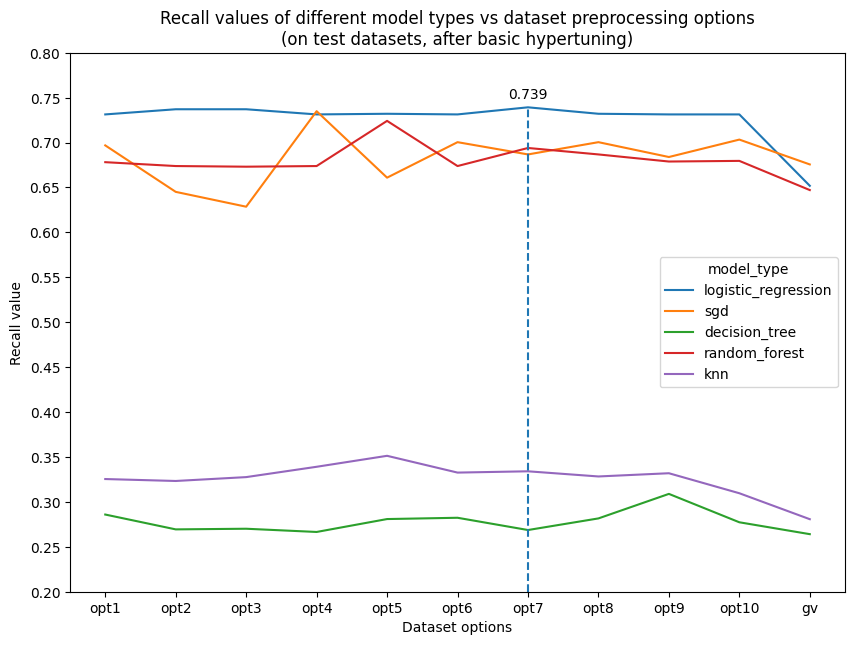

In [93]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
palette = sns.color_palette()
sns.lineplot(data=models_results[models_results['dataset_type'] == 'test'], x='dataset_option', y='recall', hue='model_type', ax=axs)
axs.plot([lr_max_idx, lr_max_idx], [0.2, lr_max_val], '--', color=palette[0])
axs.annotate(str(np.round(lr_max_val ,3)), xy=(lr_max_idx, lr_max_val+0.01), ha='center')
axs.set_ybound(lower=0.2, upper=0.8)
axs.set_xlabel('Dataset options')
axs.set_ylabel('Recall value')
axs.set_yticks(np.arange(0.2, 0.81, 0.05))
axs.set_title('Recall values of different model types vs dataset preprocessing options\n(on test datasets, after basic hypertuning)');

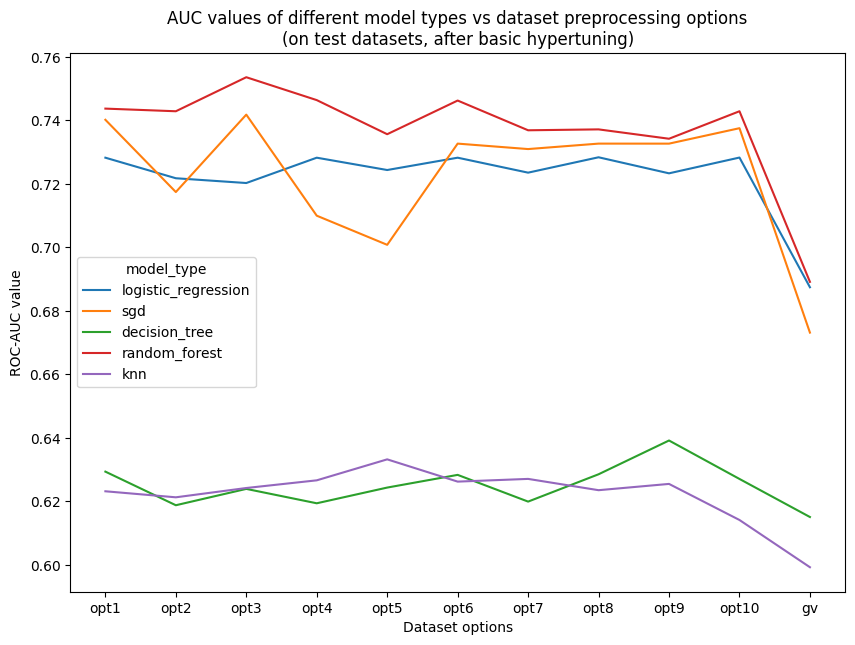

In [37]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
sns.lineplot(data=models_results[models_results['dataset_type'] == 'test'], x='dataset_option', y='auc', hue='model_type', ax=axs)
#axs.set_ybound(lower=0.2, upper=0.8)
axs.set_xlabel('Dataset options')
axs.set_ylabel('ROC-AUC value')
axs.set_title('AUC values of different model types vs dataset preprocessing options\n(on test datasets, after basic hypertuning)');

Scores:
Indicator  	Train 	Test
accuracy:     	0.7020 	0.7113
precision:     	0.2321 	0.2431
recall:     	0.7127 	0.7392
f1:     	0.3502 	0.3659
auc:     	0.7067 	0.7235


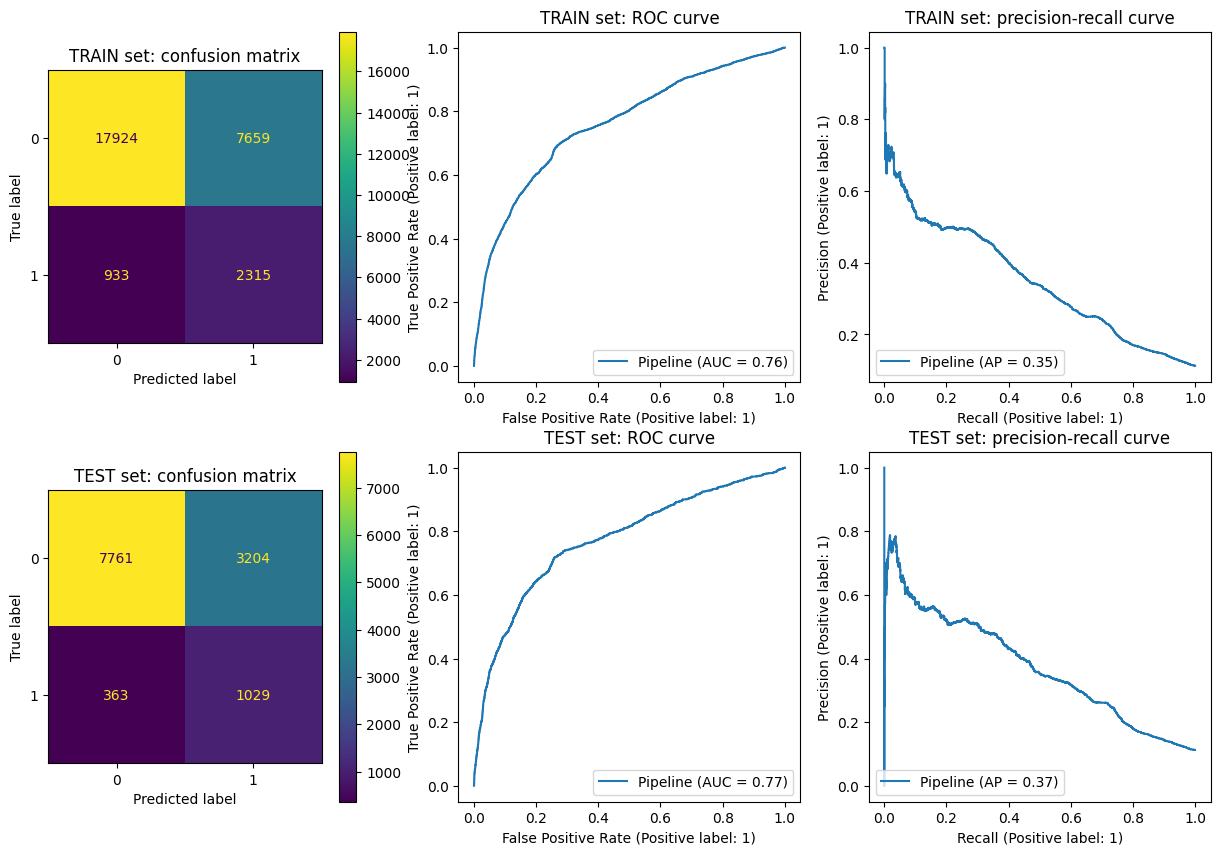

In [104]:
df_train = pd.read_csv('datasets/processed/bank-train-encoded-opt7.csv', comment='#')
df_test = pd.read_csv('datasets/processed/bank-test-encoded-opt7.csv', comment='#')
X_train = df_train.drop(columns=['y'])
y_train = df_train['y']
X_test = df_test.drop(columns=['y'])
y_test = df_test['y']
clf = pickle.load(open('models/logistic_regression-opt7.pkl', 'rb'))
clf_res = get_model_results(model=clf, train_set=(X_train, y_train), test_set=(X_test,y_test), show_charts=True)

In [38]:
df = pd.read_csv('datasets/processed/bank-full-encoded-gv.csv')
print('Average call duration is {:.1f} minute(s)'.format(df['duration'].mean()/60))

Average call duration is 3.4 minute(s)


Average long-term deposit rate ~3%  
Average credit rate ~4%  
Total sum of deposits as of 2021 - $281 bln  
Total population as of 2021 - 10,3 mln  
0-15 y.o. ratio - 13.58%  
Mobile plan - $0.15 / minute  
Average call duration - 3.4 minutes (mean value from dataset)  
  
Population able to have deposit = 10.3 * (1- 0.1358) ~ 8.9 mln  
Average deposit sum = 281 000 / 8.9 ~ $31 600  
Bank margin = 4.0% - 3.0% = 1%  
Average margin from 1 deposit per month (possible duration of the campaign) = 31 600 * 0.01 / 12 ~ $26.3 / mo  
Average cost of call - 3.4 * 0.15 ~ $0.5

In [39]:
conf_matrixes = {}
for df_name, df_unit in tqdm(dfs.items()):
    print(f'Processing dataset {df_name}')
    #X_train = df_unit['train'].drop(columns=[x for x in ['y', 'duration'] if x in df_unit['train'].columns])
    #y_train = df_unit['train']['y']
    X_test = df_unit['test'].drop(columns=[x for x in ['y', 'duration'] if x in df_unit['test'].columns])
    y_test = df_unit['test']['y']
    for model_name in models2process:
        model_filename = 'models/' + model_name + '-' + df_name + '.pkl'
        print('Loading model: ', model_filename.split('/')[1])
        model = pickle.load(open(model_filename, 'rb'))
        conf_matrixes[Path(model_filename).stem] = confusion_matrix(y_test, model.predict(X_test))

  0%|          | 0/11 [00:00<?, ?it/s]

Processing dataset opt1
Loading model:  logistic_regression-opt1.pkl
Loading model:  sgd-opt1.pkl
Loading model:  decision_tree-opt1.pkl
Loading model:  random_forest-opt1.pkl
Loading model:  knn-opt1.pkl


  9%|▉         | 1/11 [00:42<07:09, 42.92s/it]

Processing dataset opt2
Loading model:  logistic_regression-opt2.pkl
Loading model:  sgd-opt2.pkl
Loading model:  decision_tree-opt2.pkl
Loading model:  random_forest-opt2.pkl
Loading model:  knn-opt2.pkl


 18%|█▊        | 2/11 [00:44<02:48, 18.76s/it]

Processing dataset opt3
Loading model:  logistic_regression-opt3.pkl
Loading model:  sgd-opt3.pkl
Loading model:  decision_tree-opt3.pkl
Loading model:  random_forest-opt3.pkl
Loading model:  knn-opt3.pkl


 27%|██▋       | 3/11 [00:45<01:25, 10.68s/it]

Processing dataset opt4
Loading model:  logistic_regression-opt4.pkl
Loading model:  sgd-opt4.pkl
Loading model:  decision_tree-opt4.pkl
Loading model:  random_forest-opt4.pkl
Loading model:  knn-opt4.pkl


 36%|███▋      | 4/11 [00:47<00:51,  7.29s/it]

Processing dataset opt5
Loading model:  logistic_regression-opt5.pkl
Loading model:  sgd-opt5.pkl
Loading model:  decision_tree-opt5.pkl
Loading model:  random_forest-opt5.pkl
Loading model:  knn-opt5.pkl


 45%|████▌     | 5/11 [00:49<00:30,  5.08s/it]

Processing dataset opt6
Loading model:  logistic_regression-opt6.pkl
Loading model:  sgd-opt6.pkl
Loading model:  decision_tree-opt6.pkl
Loading model:  random_forest-opt6.pkl
Loading model:  knn-opt6.pkl


 55%|█████▍    | 6/11 [00:51<00:20,  4.09s/it]

Processing dataset opt7
Loading model:  logistic_regression-opt7.pkl
Loading model:  sgd-opt7.pkl
Loading model:  decision_tree-opt7.pkl
Loading model:  random_forest-opt7.pkl
Loading model:  knn-opt7.pkl


 64%|██████▎   | 7/11 [00:53<00:13,  3.42s/it]

Processing dataset opt8
Loading model:  logistic_regression-opt8.pkl
Loading model:  sgd-opt8.pkl
Loading model:  decision_tree-opt8.pkl
Loading model:  random_forest-opt8.pkl
Loading model:  knn-opt8.pkl


 73%|███████▎  | 8/11 [00:55<00:09,  3.00s/it]

Processing dataset opt9
Loading model:  logistic_regression-opt9.pkl
Loading model:  sgd-opt9.pkl
Loading model:  decision_tree-opt9.pkl
Loading model:  random_forest-opt9.pkl
Loading model:  knn-opt9.pkl


 82%|████████▏ | 9/11 [00:57<00:05,  2.68s/it]

Processing dataset opt10
Loading model:  logistic_regression-opt10.pkl
Loading model:  sgd-opt10.pkl
Loading model:  decision_tree-opt10.pkl
Loading model:  random_forest-opt10.pkl
Loading model:  knn-opt10.pkl


 91%|█████████ | 10/11 [00:59<00:02,  2.55s/it]

Processing dataset gv
Loading model:  logistic_regression-gv.pkl
Loading model:  sgd-gv.pkl
Loading model:  decision_tree-gv.pkl
Loading model:  random_forest-gv.pkl
Loading model:  knn-gv.pkl


100%|██████████| 11/11 [01:00<00:00,  5.53s/it]


We can organize financial results per call in the way corresponding to confusion matrix:  
- true negatives = 0 as we don't call them
- true positives = margin per positive
- false positives = margin per negative as we call them but they refuse to open deposit
- false negatives = lost profit as we don't call them but they could open deposit 

In [65]:
def get_margin_matrix(pos_income, cost_per_call_ratio, lost_income=True):
    pos_margin = pos_income * (1 - cost_per_call_ratio)
    neg_margin = -pos_income * cost_per_call_ratio
    if lost_income:
        return np.array([0, neg_margin, -pos_margin, pos_margin]).reshape(2, 2)
    else:
        return np.array([0, neg_margin, 0, pos_margin]).reshape(2, 2)

In [40]:
pos_income = 26.3
cost_per_call_ratio = 0.02
margin_per_positive = 26.3 - 0.5 # for positive (customer opens deposit) = interest sum - call cost
margin_per_negative = -0.5 # for negative (customer doesn't open deposit) = - call cost

margin = np.array([0, margin_per_negative, -margin_per_positive, margin_per_positive]).reshape(2, 2)
margin

array([[  0. ,  -0.5],
       [-25.8,  25.8]])

In [42]:
get_margin_matrix(pos_income=pos_income, cost_per_call_ratio=0.05)

array([[  0.   ,  -1.315],
       [-24.985,  24.985]])

In [66]:
get_margin_matrix(pos_income=pos_income, cost_per_call_ratio=0.05, lost_income=False)

array([[ 0.   , -1.315],
       [ 0.   , 24.985]])

In [43]:
conf_matrixes['logistic_regression-opt4']

array([[7951, 3014],
       [ 374, 1018]], dtype=int64)

Thus financial result from using each model can be calculated by element-wise multiplication of confusion matrix and margin matrix and summing all elements at the end

In [44]:
(conf_matrixes[list(conf_matrixes.keys())[0]] * margin).sum()

15108.2

In [45]:
conf_matrixes.keys()

dict_keys(['logistic_regression-opt1', 'sgd-opt1', 'decision_tree-opt1', 'random_forest-opt1', 'knn-opt1', 'logistic_regression-opt2', 'sgd-opt2', 'decision_tree-opt2', 'random_forest-opt2', 'knn-opt2', 'logistic_regression-opt3', 'sgd-opt3', 'decision_tree-opt3', 'random_forest-opt3', 'knn-opt3', 'logistic_regression-opt4', 'sgd-opt4', 'decision_tree-opt4', 'random_forest-opt4', 'knn-opt4', 'logistic_regression-opt5', 'sgd-opt5', 'decision_tree-opt5', 'random_forest-opt5', 'knn-opt5', 'logistic_regression-opt6', 'sgd-opt6', 'decision_tree-opt6', 'random_forest-opt6', 'knn-opt6', 'logistic_regression-opt7', 'sgd-opt7', 'decision_tree-opt7', 'random_forest-opt7', 'knn-opt7', 'logistic_regression-opt8', 'sgd-opt8', 'decision_tree-opt8', 'random_forest-opt8', 'knn-opt8', 'logistic_regression-opt9', 'sgd-opt9', 'decision_tree-opt9', 'random_forest-opt9', 'knn-opt9', 'logistic_regression-opt10', 'sgd-opt10', 'decision_tree-opt10', 'random_forest-opt10', 'knn-opt10', 'logistic_regression-gv'

In [46]:
fin_res = np.zeros((len(dfs), len(models2process)))
index = []
columns = []
for label, matrix in conf_matrixes.items(): 
    # label is '<model_name>-<df_type>'
    model_name = label.split('-')[0]
    df_type = label.split('-')[1]
    if df_type not in index:
        index.append(df_type)
    if model_name not in columns:
        columns.append(model_name)
    i = index.index(df_type)
    j = columns.index(model_name)
    fin_res[i, j] = (matrix * margin).sum()
fin_res = pd.DataFrame(fin_res, index=index, columns=columns)
fin_res

,logistic_regression,sgd,decision_tree,random_forest,knn
opt1,15108.2,12951.4,-15526.3,11750.8,-12972.8
opt2,15418.5,9270.2,-16738.6,11455.7,-13136.6
opt3,15402.0,8441.4,-16634.5,11525.6,-12818.5
opt4,15108.2,15146.2,-16922.5,11494.2,-12029.4
opt5,15113.3,10136.4,-15915.0,14712.7,-11146.7
opt6,15108.2,13107.4,-15775.8,11492.7,-12462.8
opt7,15580.8,12183.0,-16773.7,12724.5,-12358.1
opt8,15157.3,13107.4,-15821.4,12251.0,-12778.4
opt9,15054.2,12011.1,-13893.6,11694.4,-12518.4
opt10,15108.7,13351.3,-16123.5,11837.0,-14120.5


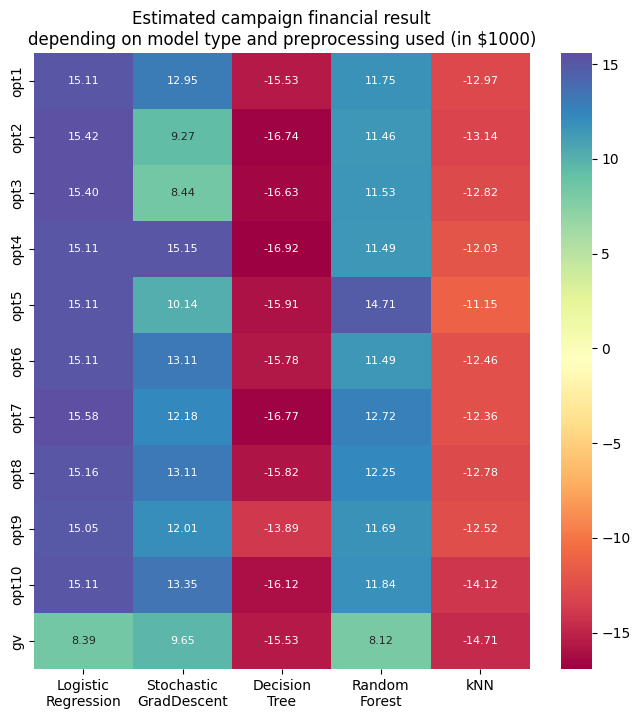

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(data=fin_res/1000, annot=True, cmap=sns.color_palette("Spectral", as_cmap=True), fmt='.2f', annot_kws={'fontsize': 8}, ax=ax)
ax.set_xticklabels(['Logistic\nRegression', 'Stochastic\nGradDescent', 'Decision\nTree', 'Random\nForest', 'kNN']) #, rotation=35, ha='right'
ax.set_title('Estimated campaign financial result\ndepending on model type and preprocessing used (in $1000)');

Sensitivity of different models to costs per call value

In [50]:
# baselines: (1) call to all customers and (2) call to customers from clusters with higher probability of positive outcome
# data is taken from 6_clustering.ipynb
clusters_cms = {
    0: np.array([0, 7951, 0, 374]).reshape(2, 2),
    1: np.array([0, 2207, 0, 347]).reshape(2, 2),
    2: np.array([0, 321, 0, 191]).reshape(2, 2),
    3: np.array([0, 486, 0, 480]).reshape(2, 2)
}
clusters_cms

{0: array([[   0, 7951],
        [   0,  374]]),
 1: array([[   0, 2207],
        [   0,  347]]),
 2: array([[  0, 321],
        [  0, 191]]),
 3: array([[  0, 486],
        [  0, 480]])}

In [51]:
def get_clusters_cm(clusters_cms, include):
    if len(clusters_cms) != len(include):
        raise ValueError('Arguments have different lengths')
    result = np.zeros(shape=(2, 2))
    for key, cm in clusters_cms.items():
        if not include[key]:
            temp = np.hstack((cm[:, 1].reshape(-1, 1), cm[:, 0].reshape(-1, 1)))
        else:
            temp = cm
        result += temp
    return result

In [52]:
include_test = {0: False, 1: True, 2: True, 3: True}
get_clusters_cm(clusters_cms=clusters_cms, include=include_test)

array([[7951., 3014.],
       [ 374., 1018.]])

In [67]:
def get_sens_data(x_range, cm, pos_income, lost_income=True):
    sens_data = None
    for x in x_range:
        mm = get_margin_matrix(pos_income=pos_income, cost_per_call_ratio=x, lost_income=lost_income)
        if sens_data is None:
            sens_data = np.array([x, np.max((0, (mm * cm).sum()))])
        else:
            sens_data = np.vstack((sens_data, np.array([x, np.max((0, (mm * cm).sum()))])))
    return sens_data

In [54]:
include_all = {0: True, 1: True, 2: True, 3: True}
include_3 = {0: False, 1: True, 2: True, 3: True}
baseline_all = get_sens_data(np.arange(0, 1.01, 0.01), get_clusters_cm(clusters_cms=clusters_cms, include=include_all), pos_income)
baseline_3 = get_sens_data(np.arange(0, 1.01, 0.01), get_clusters_cm(clusters_cms=clusters_cms, include=include_3), pos_income)

In [69]:
s_sgd4 = get_sens_data(np.arange(0, 1.01, 0.01), conf_matrixes['sgd-opt4'], pos_income)
s_sgd2 = get_sens_data(np.arange(0, 1.01, 0.01), conf_matrixes['sgd-opt2'], pos_income)
s_rf5 = get_sens_data(np.arange(0, 1.01, 0.01), conf_matrixes['random_forest-opt5'], pos_income)
s_lr7 = get_sens_data(np.arange(0, 1.01, 0.01), conf_matrixes['logistic_regression-opt7'], pos_income)
s_lr2 = get_sens_data(np.arange(0, 1.01, 0.01), conf_matrixes['sgd-opt2'], pos_income)

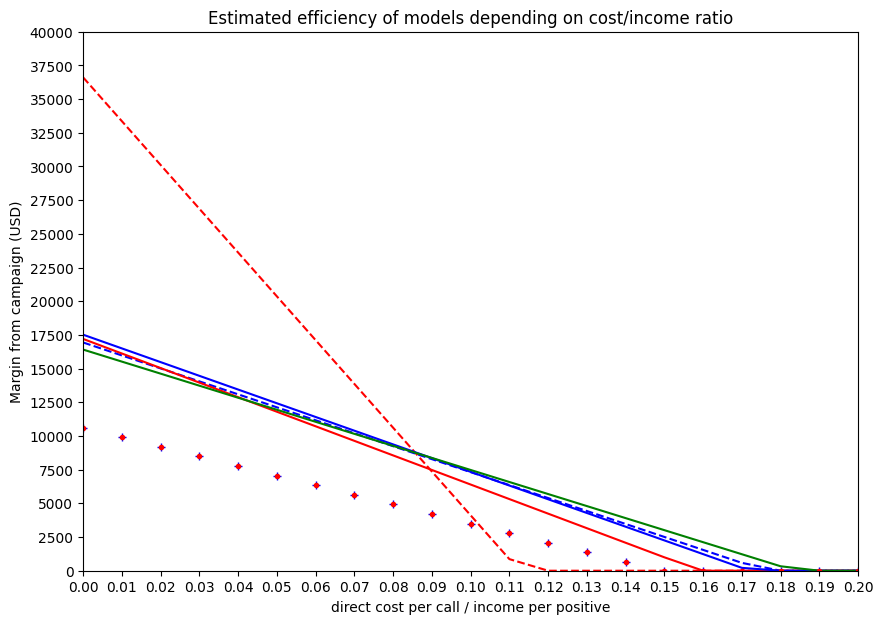

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.plot(baseline_all[:, 0], baseline_all[:, 1], 'r--', label='all clients')
ax.plot(baseline_3[:, 0], baseline_3[:, 1], 'b--', label='clients with >10% positive probability')
ax.plot(s_sgd4[:, 0], s_sgd4[:, 1], 'r-', label='SGD')
ax.plot(s_lr7[:, 0], s_lr7[:, 1], 'b-')
ax.plot(s_rf5[:, 0], s_rf5[:, 1], 'g-')
ax.plot(s_lr2[:, 0], s_lr2[:, 1], 'b+')
ax.plot(s_sgd2[:, 0], s_sgd2[:, 1], 'r.')
ax.set_xbound(lower=0, upper=0.2)
ax.set_xticks(np.arange(0, 0.21, 0.01))
ax.set_xlabel('direct cost per call / income per positive')
ax.set_ybound(lower=0)
ax.set_yticks(np.arange(0, 40001, 2500))
ax.set_ylabel('Margin from campaign (USD)')
ax.set_title('Estimated efficiency of models depending on cost/income ratio');

In [71]:
# calculating financial data with no lost income factor
baseline_all_nolostincome = get_sens_data(np.arange(0, 1.01, 0.01), get_clusters_cm(clusters_cms=clusters_cms, include=include_all), pos_income, lost_income=False)
baseline_3_nolostincome = get_sens_data(np.arange(0, 1.01, 0.01), get_clusters_cm(clusters_cms=clusters_cms, include=include_3), pos_income, lost_income=False)
s_sgd4_nolostincome = get_sens_data(np.arange(0, 1.01, 0.01), conf_matrixes['sgd-opt4'], pos_income, lost_income=False)
s_sgd2_nolostincome = get_sens_data(np.arange(0, 1.01, 0.01), conf_matrixes['sgd-opt2'], pos_income, lost_income=False)
s_rf5_nolostincome = get_sens_data(np.arange(0, 1.01, 0.01), conf_matrixes['random_forest-opt5'], pos_income, lost_income=False)
s_lr7_nolostincome = get_sens_data(np.arange(0, 1.01, 0.01), conf_matrixes['logistic_regression-opt7'], pos_income, lost_income=False)
s_lr2_nolostincome = get_sens_data(np.arange(0, 1.01, 0.01), conf_matrixes['sgd-opt2'], pos_income, lost_income=False)

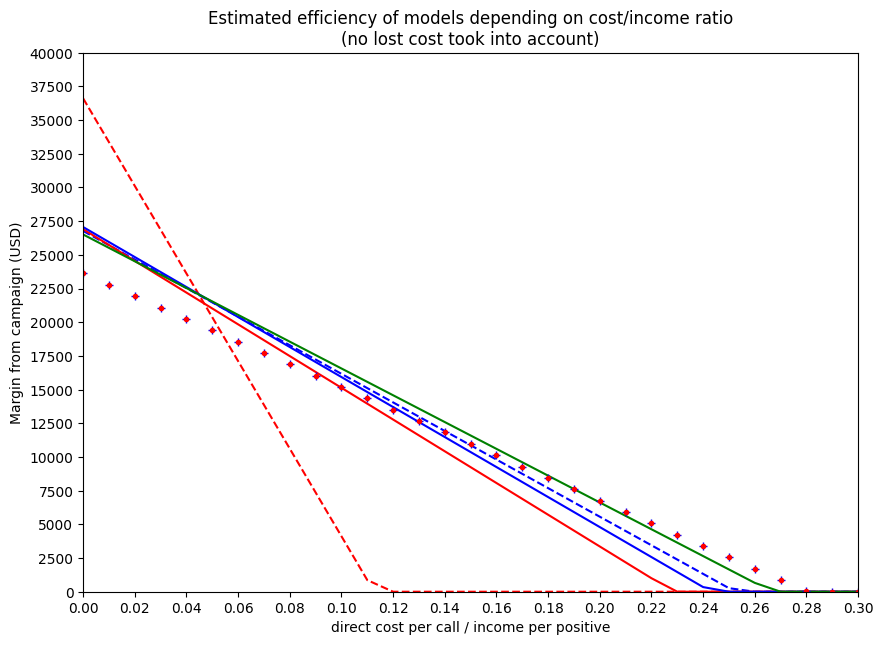

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.plot(baseline_all_nolostincome[:, 0], baseline_all_nolostincome[:, 1], 'r--', label='all clients')
ax.plot(baseline_3_nolostincome[:, 0], baseline_3_nolostincome[:, 1], 'b--', label='clients with >10% positive probability')
ax.plot(s_sgd4_nolostincome[:, 0], s_sgd4_nolostincome[:, 1], 'r-', label='SGD')
ax.plot(s_lr7_nolostincome[:, 0], s_lr7_nolostincome[:, 1], 'b-')
ax.plot(s_rf5_nolostincome[:, 0], s_rf5_nolostincome[:, 1], 'g-')
ax.plot(s_lr2_nolostincome[:, 0], s_lr2_nolostincome[:, 1], 'b+')
ax.plot(s_sgd2_nolostincome[:, 0], s_sgd2_nolostincome[:, 1], 'r.')
ax.set_xbound(lower=0, upper=0.3)
ax.set_xticks(np.arange(0, 0.31, 0.02))
ax.set_xlabel('direct cost per call / income per positive')
ax.set_ybound(lower=0)
ax.set_yticks(np.arange(0, 40001, 2500))
ax.set_ylabel('Margin from campaign (USD)')
ax.set_title('Estimated efficiency of models depending on cost/income ratio\n(no lost cost took into account)');